In [62]:
import numpy as np
import pandas as pd

In [63]:
# get data
X_train: pd.DataFrame = pd.read_csv("../X_train.csv")
y_train: pd.DataFrame = pd.read_csv("../y_train.csv")

X_test_1: pd.DataFrame = pd.read_csv("../X_test_1.csv")
# which will be tested against y_test_1

# y_test_2 provides labels for first 202 rows in X_test_2
X_test_2: pd.DataFrame = pd.read_csv("../X_test_2.csv")
y_test_2: pd.DataFrame = pd.read_csv("../y_test_2_reduced.csv")

print(X_train.shape, y_train.shape)
print(X_test_2.shape, y_test_2.shape)

(10000, 300) (10000, 1)
(2020, 300) (202, 1)


In [64]:
# select features
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
from matplotlib import pyplot as plt

In [65]:
def threshold_variance(this_X: pd.DataFrame, threshold=0.1):
    # remove low variance
    variance_selector = VarianceThreshold(threshold=threshold)
    X_reduced = variance_selector.fit_transform(this_X)

    # get feature names that passed the threshold
    selected_features = this_X.columns[variance_selector.get_support()]

    # optionally scale after thresholding
    X_scaled = StandardScaler().fit_transform(X_reduced)

    print(f"Threshold reduced shape: {X_scaled.shape}")
    return X_scaled, selected_features


In [66]:
# table of class distribution in y_train
y_train_distribution = y_train.value_counts().reset_index()
y_train_distribution.columns = ['class', 'count']
print(y_train_distribution)

    class  count
0       5   4479
1      10   1081
2       6    553
3       8    516
4      12    457
5      24    385
6      17    354
7      26    278
8      21    269
9      14    264
10      4    238
11     25    184
12     19    177
13     20    153
14     27    107
15      7    103
16     11     78
17      3     65
18     13     62
19     18     60
20     23     41
21     15     26
22      9     25
23      0     18
24      1      7
25     22      7
26      2      7
27     16      6


In [67]:
# # use smote (for posterity, should use smote after split)
# smote = SMOTE(random_state=42)
# X = X_train.copy().to_numpy()
# y = y_train.copy().to_numpy().reshape(-1)
# print(X.shape, y.shape)
# print(type(X), type(y))
# X, y = smote.fit_resample(X, y)
# if smote:
#     print(f"SMOTE generated an additional {X.shape[0] - X_train.shape[0]} samples.")
#     y_resampled_distribution = pd.DataFrame(y).value_counts().reset_index()
#     y_resampled_distribution.columns = ["class", "count"]
#     print(y_resampled_distribution)

In [68]:
# create pipeline

# estimator = RandomForestClassifier(criterion="entropy") takes too long
estimator = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
    class_weight=None, # None for SMOTE, "balanced" for no SMOTE
    random_state=42
)

cv = StratifiedKFold(n_splits=4)

rfecv = RFECV(
    estimator=estimator,
    step=10,
    cv=cv,
    scoring="f1_macro", # f1 weighted for multiclass imbalance too (when not using smote)
    n_jobs=-1
)

train_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("feature_selection", rfecv),
    ("classifier", estimator)
])

X = X_train
y = y_train

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [69]:
# # apply smote
# X_train = X_train.values
# y_train = y_train.values.reshape(-1)
# print(type(X_train), type(y_train))
# print(X_train.shape, y_train.shape)
# # set min samples explicitly since imbalanced
# neighbours = 3
# smote = SMOTE(random_state=42, k_neighbors=neighbours)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# if smote:
#     print(f"SMOTE generated an additional {X_train_smote.shape[0] - X_train.shape[0]} samples.")
#     y_resampled_distribution = pd.DataFrame(y_train_smote).value_counts().reset_index()
#     y_resampled_distribution.columns = ["class", "count"]
#     print(y_resampled_distribution)
#
#     X_train = X_train_smote
#     y_train = y_train_smote

In [70]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

def lasso_regularisation(this_X, this_y, alpha=0.01):
    # scale just for lasso
    X_scaled = StandardScaler().fit_transform(this_X)

    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_scaled, this_y)
    this_selected_features = np.where(np.abs(lasso.coef_) > 0)[0]
    X_reduced = this_X[:, this_selected_features]
    print(f"lasso regularisation removed {this_X.shape[1] - len(this_selected_features)} features")
    return X_reduced, this_selected_features

In [71]:
# train_pipeline.fit(X_train_smote, y_train_smote)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy().reshape(-1)
X_train, selected_features = lasso_regularisation(X_train, y_train, alpha=0.05)
X_val = X_val.to_numpy()[:, selected_features]
train_pipeline.fit(X_train, y_train)
y_pred = train_pipeline.predict(X_val)
y_proba = train_pipeline.predict_proba(X_val)

lasso regularisation removed 140 features


In [72]:
n_features = train_pipeline.named_steps['feature_selection'].n_features_
print(f"Number of features selected: {n_features}")

Number of features selected: 140


In [73]:
support_mask = train_pipeline.named_steps['feature_selection'].support_
selected_feature_indices = np.where(support_mask)[0]
print(f"Selected feature indices: {selected_feature_indices}")

Selected feature indices: [  0   1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  59  60  61  62  63  64  65  66  67  68  70  71  72  73  74  75
  77  78  79  80  81  82  83  86  89  91  92  93  94  95  96  97  98  99
 100 101 103 106 107 108 109 110 111 112 115 117 118 119 120 121 123 124
 125 126 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 154 155 156 157 159]


In [74]:
def plot_confusion_matrix(this_y_val, this_y_pred, classes=range(28), normalize=True, title="Confusion Matrix (Validation Set)"):
    cm = confusion_matrix(this_y_val, this_y_pred)

    class_labels = [f"Class {i}" for i in classes]
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt=".1f", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

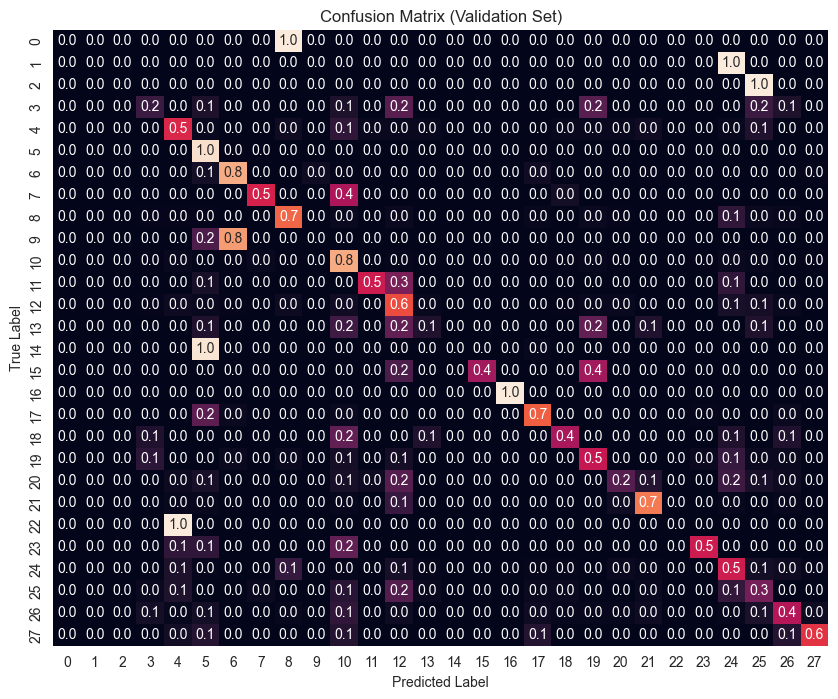

In [75]:
plot_confusion_matrix(y_val, y_pred, classes=range(28), normalize=True, title="Confusion Matrix (Validation Set)")

In [76]:
print(classification_report(y_pred=y_pred, y_true=y_val))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.12      0.15      0.14        13
           4       0.52      0.54      0.53        48
           5       0.90      0.97      0.94       896
           6       0.88      0.84      0.86       111
           7       0.65      0.52      0.58        21
           8       0.74      0.68      0.71       103
           9       0.00      0.00      0.00         5
          10       0.77      0.83      0.80       216
          11       0.73      0.50      0.59        16
          12       0.53      0.63      0.57        91
          13       0.14      0.08      0.11        12
          14       0.00      0.00      0.00        53
          15       1.00      0.40      0.57         5
          16       1.00      1.00      1.00         1
          17       0.69    

/Users/archiecollison/Developer/cse/cs9417/project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/archiecollison/Developer/cse/cs9417/project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/archiecollison/Developer/cse/cs9417/project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

In [78]:
# test against test_2 (unexpected model performance)
X_test_2_labelled = X_test_2.copy()[:202] # only labelled
print(X_test_2_labelled.shape)
y_pred_2 = train_pipeline.predict(X_test_2_labelled.to_numpy()[:, selected_features])

(202, 300)


In [79]:
print(classification_report(y_pred=y_pred_2, y_true=y_test_2))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.43      0.75      0.55         4
           5       0.47      1.00      0.64         9
           6       0.50      1.00      0.67         3
           7       0.80      0.29      0.42        14
           8       0.83      0.83      0.83        29
           9       0.00      0.00      0.00         3
          10       0.13      1.00      0.24         2
          11       1.00      0.89      0.94         9
          12       0.73      0.63      0.68        43
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         1
          17       1.00      0.70      0.82        10
          18       0.00      0.00      0.00         1
          19       0.40      0.50      0.44         4
          20       0.20    

/Users/archiecollison/Developer/cse/cs9417/project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/archiecollison/Developer/cse/cs9417/project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/archiecollison/Developer/cse/cs9417/project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

/var/folders/f2/41dfqkfn37jdnzpl74jrw37r0000gn/T/ipykernel_10183/2250770255.py:5: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


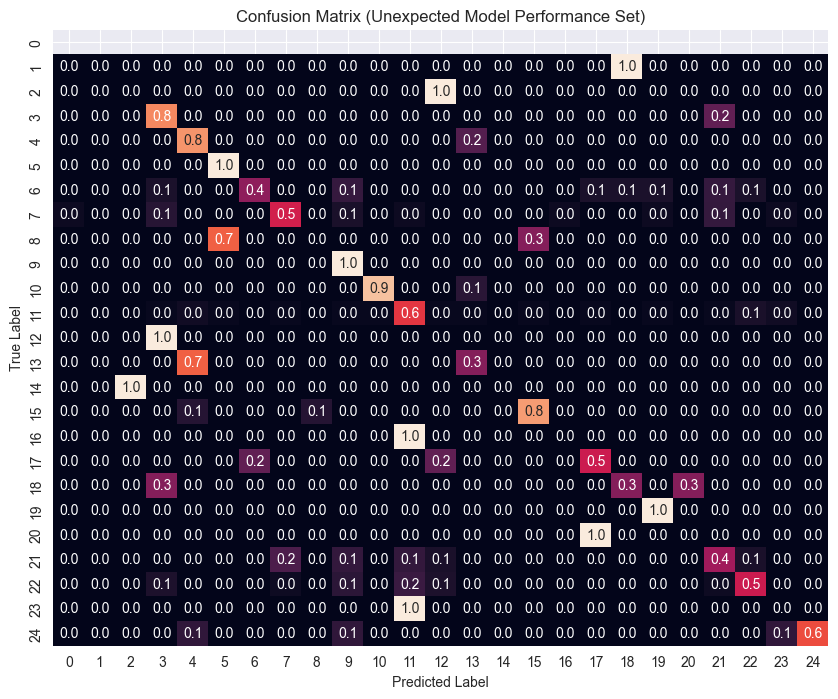

In [196]:
plot_confusion_matrix(y_test_2, y_pred_2, classes=range(28), normalize=True, title="Confusion Matrix (Unexpected Model Performance Set)")

# Overview
SMOTE helped improve original train/test performance. It used augmentation to generate an additional 115412 training samples for 4479 samples per class.
We achieve (on validation set):
- weighted avg precision, recall, f1: 0.73 0.67 0.69

However, on the unexpected test set:
- precision, recall, f1-score all tanked
- this indicates a struggle to generalise to new data.
- this could be due to overfitting (smote generated too much data?), concept drift, or the model memorising patterns only present in the test data
